In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from scipy.ndimage import morphology

import get_halpha_SB

%matplotlib inline

machine = 'chinook'

Locate the data

In [2]:
if machine == 'chinook':
    homedir = '/Users/lokhorst/Desktop/PipelineTesting/'
if machine == 'coho':
    homedir = '/Users/deblokhorst/Desktop/tmp/'

In [3]:
coadd_file=homedir+'2017-04-02_coadd_SloanG.fits'

imagenames=[]
if machine=='chinook':
    imagenames = ['2017-04-02_T13090552_16_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
                  '2017-04-02_T13110598_31_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
                  '2017-04-02_T13110627_36_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
                  '2017-04-02_T13090562_23_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
                  '2017-04-02_T13110625_22_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
                  '2017-04-02_T13110630_19_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
                  '2017-04-02_T13090571_19_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
                  '2017-04-02_T13110627_21_light_ds_ff_wcs_sms_reg_pcp_pcr.fits', 
                  '2017-04-02_T13110630_40_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
                  '2017-04-02_T13100579_15_light_ds_ff_wcs_sms_reg_pcp_pcr.fits' 
                  ,'2017-04-02_T13110627_26_light_ds_ff_wcs_sms_reg_pcp_pcr.fits'
                 ]
if machine=='coho':
    imagenames = ['2017-04-02_T13090552_16_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
                  '2017-04-02_T13090562_23_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
                  '2017-04-02_T13090571_19_light_ds_ff_wcs_sms_reg_pcp_pcr.fits',
                  '2017-04-02_T13100579_15_light_ds_ff_wcs_sms_reg_pcp_pcr.fits']


Load the data

In [20]:
d_needle279,h_needle279 = fits.getdata(coadd_file,header=True)

print 'There are %s frames combined in %s.' % (np.float(h_needle279['NFRAMES']),'2017-04-02_coadd_SloanG.fits')

d_needle1,h_needle1 = fits.getdata(homedir+imagenames[0],header=True)
print h_needle1

There are 279.0 frames combined in 2017-04-02_coadd_SloanG.fits.
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 5750                                                  NAXIS2  =                 4250                                                  EQUINOX =        2000.00000000 / Mean equinox                                   RADESYS = 'ICRS    '           / Astrometric system                             CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              CUNIT1  = 'deg     '           / Axis unit                                      CRVAL1  =   1.890866666667E+02 / World coordinate on this axis                  CRPIX1  =   2.875500000000E+03 / Reference pixel on this axis                   CD1_1   =  -6.944444444444E-04 / Linear projection matr

Define plotting scripts

In [5]:
def plotdata(data,ax=None,bounds=None,colorbar=False):
    if ax is None:
        fig = plt.figure(figsize=(6, 3.2))
        ax = fig.add_subplot(111)
        oneplot=True
    if bounds is None:
        img = ax.imshow(data,origin='lower',interpolation='nearest')
    else:
        img = ax.imshow(data,origin='lower',vmin=bounds[0],vmax=bounds[1],interpolation='nearest')
    ax.set_aspect('equal')
    
    if colorbar:
        div = axgrid.make_axes_locatable(ax)
        cax = div.append_axes("right",size="10%",pad=0.15)
        cbar = plt.colorbar(img,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
        cbar.ax.tick_params()

In [6]:
def maskbox(data,center_x,center_y,size=100,niter=5):
    '''
    Cut out a box centered on (center_x, center_y) with pixel dimensions (2*size)^2.
    Sigma clip the data box, use outliers to create a mask.
    Mask the image with the outliers mask and use the masked image to find the standard deviation of the noise.
    '''
    ## Plot the original data
    smaller_d = data[center_x-size:center_x+size,center_y-size:center_y+size]
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 16))
    plotdata(np.log10(smaller_d),ax=ax1)
    ax1.set_title('data')
    ax1.text(0,(size*2)*0.8,"median: %.2f \nsigma: %.2f"%(np.median(smaller_d),np.std(smaller_d)),\
             bbox=dict(facecolor='white', edgecolor='black'))
    
    ## Plot the mask (made from sigma clipping)
    clipped_d  = sigma_clip(smaller_d, sig=3, iters = niter)
    outliers   = clipped_d.mask
    plotdata(outliers,ax=ax2)
    ax2.set_title('mask')
    
    # grow the mask a bit in all directinos
    growmask = morphology.grey_dilation(outliers,(3,3))
    plotdata(growmask,ax=ax3)
    ax3.set_title('grow mask')
    
    ## Plot the masked data
    mx = np.ma.masked_array(smaller_d, mask=growmask)
    plotdata(mx,ax=ax4)
    ax4.set_title('masked data')
    ax4.text(0,(size*2)*0.8,"median: %.2f \nsigma: %.2f"%(np.ma.median(mx),np.ma.std(mx)),\
             bbox=dict(facecolor='white', edgecolor='black'))
    
    plt.tight_layout()
    return

def plotbox(center_x=2100,center_y=2100,ax=None,size=100):
    ax.plot([center_x-size,center_x+size,center_x+size,center_x-size,center_x-size],\
            [center_y-size,center_y-size,center_y+size,center_y+size,center_y-size],'k-')

In [15]:
def plothist(data,center_x,center_y,ax=None,color=None,zero=True,label='',size=100,niter=5):
    
    smaller_d = data[center_x-size:center_x+size,center_y-size:center_y+size]
    
    # ravel out the array
    clipped_zp  = sigma_clip((smaller_d), sig=3, iters = niter)
    outliers    = clipped_zp.mask
    outliers = morphology.grey_dilation(outliers,(3,3))
    outliers = np.ravel(outliers)
    mx = np.ma.masked_array(np.ravel(smaller_d), mask=outliers)[~outliers]
    med_masked = np.median(mx)
    #print med_masked
    sigma_masked = np.std(mx)
    if len(label)>0:
        label=r'$\sigma$=%.2f, %s'%(sigma_masked,label)
    else:
        label=r'$\sigma$=%.2f'%sigma_masked    
    if zero:
        y,x,_ = ax.hist(mx-med_masked,edgecolor='black', alpha = 0.5,bins=50,color=color,label=label)
        maxy = y.max()
        ax.plot([0-sigma_masked,0-sigma_masked],[0,maxy],'--',color='gray')#,color='light'+color)
        ax.plot([0+sigma_masked,0+sigma_masked],[0,maxy],'--',color='gray')#,color='light'+color)
    else:
        y,x,_ = ax.hist(mx,edgecolor='black', alpha = 0.5,bins=50,color=color)
        maxy = y.max()
        ax.plot([med_masked,med_masked],[0,maxy],'black')
        ax.plot([med_masked-sigma_masked,med_masked-sigma_masked],[0,maxy],'--',color='gray')
        ax.plot([med_masked+sigma_masked,med_masked+sigma_masked],[0,maxy],'--',color='gray')
        
    ax.set_xlabel('counts')
    ax.set_ylim(0,maxy)
    #print maxy
    return sigma_masked


In [8]:
def imreduce_masked(img,mask,factor,fillvalue='max'):
    """
    reduces the resolution of an image by taking the mean of individual elements
    takes in a mask to mask out values to be not included in the mean
        img: 2D image array
        mask: mask for the 2D image array
        factor: factor by which to reduce the number of array elements along each axis
    examples:
    for testing: 
        image = np.array([[1,1,2,2],[1,201,2,2],[3,3,200,4],[3,3,4,4]])
    mask your mask like this:  
        clipped = sigma_clip(image,sig=3,iters=2)
        mask = clipped.mask
    """
    
    inshape = np.array(img.shape)
    
    inimg = img
    inmask = mask
    
    if np.sum(inshape%factor) != 0:
        print('Output grid must have a integer number of cells: cannot reduce image pixels by a factor %i'%factor)
        return None
    
    # split along axes into groups that will be binned
    inimg = np.array(np.split(inimg,inshape[0]/factor,axis=0))
    inimg = np.array(np.split(inimg,inshape[1]/factor,axis=-1))
    # do the same for the masks
    inmask = np.array(np.split(inmask,inshape[0]/factor,axis=0))
    inmask = np.array(np.split(inmask,inshape[1]/factor,axis=-1))
    
    # make the masked array
    x = np.ma.array(inimg, mask=inmask)
    
    # take the mean along different axes
    x = np.ma.mean(x,axis=-1)
    x = np.ma.mean(x,axis=-1)
    
    # BUT WHAT IF THERE IS ONLY MASKED DATA WITHIN A BIN...
    if True in x.mask:
        print "WARNING: At least one bin contains only masked data - will be filled to %s."%fillvalue
        if fillvalue=='mean':
            x = x.filled(x.mean())
        elif fillvalue=='max':
            x = x.filled(x.max())
        else:
            x = x.filled(fillvalue)
        return x.T

    outimg = x.data
    
    return outimg.T

In [9]:
def boundsOfOriginal(image,plotchecks=False,debug=False):
    ## returns the bounds of the original data to plot on top of another data set
    ## find the end of the first row of zeros (check to make sure not fluke by seeing if zero is next to it)
    image.shape
    ylen = image.shape[0]
    xlen = image.shape[1]
    if debug:
        print xlen, ylen
        print (d_needle1.T[xlen/2]).shape  ## this cuts a slice in the y dir, so put it halfway down the x dir
        print (d_needle1[ylen/2]).shape

    if plotchecks:
        plt.plot(np.arange(len(d_needle1.T[xlen/2])), d_needle1.T[xlen/2])
        plt.show()
        plt.plot(np.arange(len(d_needle1[ylen/2])), d_needle1[ylen/2])
        plt.show()
        plt.plot(np.arange(len(d_needle1.T[xlen/2])/2), d_needle1.T[xlen/2][0:ylen/2])
        plt.show()
        plt.plot(np.arange(len(d_needle1.T[xlen/2])/2), d_needle1.T[xlen/2][ylen/2:])
    
    start = -1
    while np.argwhere(image.T[xlen/2][0:ylen/2]==0)[start] != np.argwhere(image.T[xlen/2][0:ylen/2]==0)[start-1]+1:
        start = start-1
    ymin = np.argwhere(image.T[xlen/2][0:ylen/2]==0)[start]
    if debug:
        print start
    start = 0
    while np.argwhere(image.T[xlen/2][ylen/2:]==0)[start] != np.argwhere(image.T[xlen/2][ylen/2:]==0)[start+1]-1:
        start = start+1
    ymax = np.argwhere(image.T[xlen/2][ylen/2:]==0)[start] + ylen/2
    if debug:
        print start
        print ymin[0]-ymax[0]
    
    start = -1
    while np.argwhere(image[ylen/2][0:xlen/2]==0)[start] != np.argwhere(image[ylen/2][0:xlen/2]==0)[start-1]+1:
        start = start-1
    xmin = np.argwhere(image[ylen/2][0:xlen/2]==0)[start]
    if debug:
        print start
    start = 0
    while np.argwhere(image[ylen/2][xlen/2:]==0)[start] != np.argwhere(image[ylen/2][xlen/2:]==0)[start+1]-1:
        start = start+1
    xmax = np.argwhere(image[ylen/2][xlen/2:]==0)[start] + xlen/2
    if debug:
        print start
        print xmin[0]-xmax[0]
    
    ymax = ymin+2800
    xmax = xmin+3800
    return [ymin,ymax,xmin,xmax]


Start the main script. First just look at the noise in a box (and don't worry about binning).

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in log10


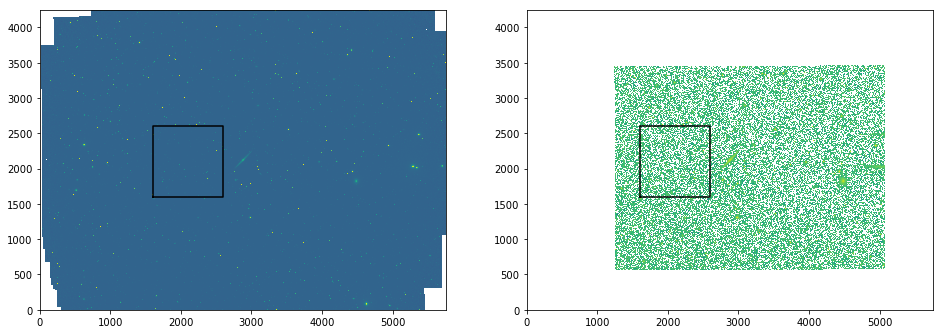

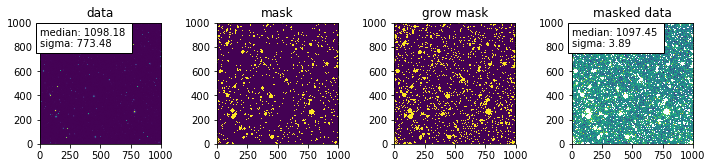

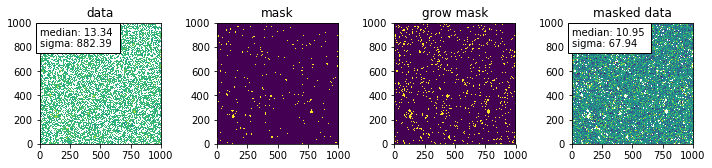

In [10]:
fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize=(16, 16))
plotdata(np.log10(d_needle279),ax=ax1)
plotdata(np.log10(d_needle1),ax=ax2)
center_x=2100; center_y=2100; size = 500  # 2900, 3700 # other x center values
plotbox(center_x,center_y,ax=ax1,size=size)
plotbox(center_x,center_y,ax=ax2,size=size)

maskbox(d_needle279,center_y,center_x,size=500)  ## switching order of x and y because ends up being transposed
print ""
maskbox(d_needle1,center_y,center_x,size=500)

Can repeat this for several frames to get an idea

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


10.9543209076
2.7085044384
2.84462380409
4.15941953659
4.25313520432
4.91804695129
3.94248652458
7.44865131378
1.50944638252
7.22928857803
3.14539527893
1097.45001864
1.83454787731
1.09926795959
1.32407736778
3.03518486023
2.61433577538
2.82910299301
3.00502586365
3.64862656593
2.64005374908
4.49926042557
4.42115020752
1097.0676031


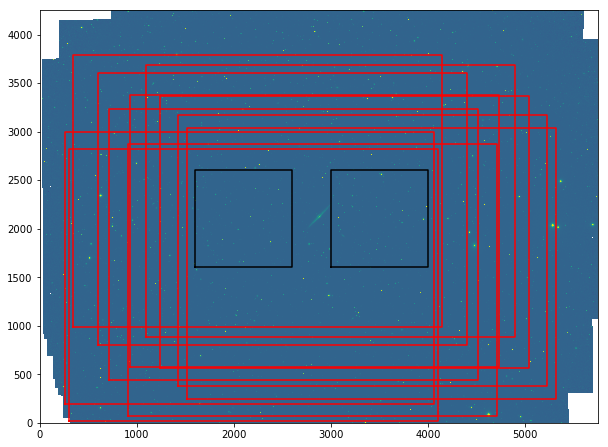

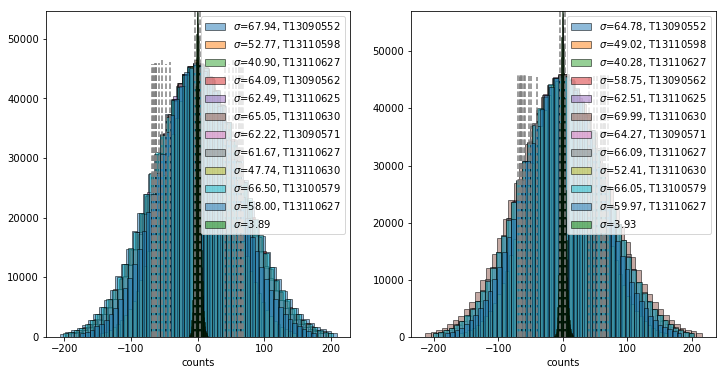

In [16]:
## Plot the outline of the different frames
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
plotdata(np.log10(d_needle279),ax=ax1)

for name in imagenames:
    image = fits.getdata(homedir+name)
    [ymin,ymax,xmin,xmax] = boundsOfOriginal(image)
    ax1.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],color='red')
    
center_x1=2100; center_y1=2100; size = 500
plotbox(center_x1,center_y1,ax=ax1,size=size)
center_x2=3500; center_y2=2100; size = 500
plotbox(center_x2,center_y2,ax=ax1,size=size)

## Plot histograms showing noise distribution in the plotbox regions from the top plot
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 6))
sigmalist = []
for image in imagenames:
    d_needle,h_needle = fits.getdata(homedir+image,header=True)
    sigma   = plothist(d_needle,center_y1,center_x1,ax=ax1,label=image.split('_')[1],size=size)
    sigmalist.append(sigma)
sigma_279 = plothist(d_needle279,center_y1,center_x1,ax=ax1,color='green',size=size)
ax1.legend()

sigmalist = []
for image in imagenames:
    d_needle,h_needle = fits.getdata(homedir+image,header=True)
    sigma   = plothist(d_needle,center_y2,center_x2,ax=ax2,label=image.split('_')[1],size=size)
    sigmalist.append(sigma)
sigma_279 = plothist(d_needle279,center_y2,center_x2,ax=ax2,color='green',size=size)
ax2.legend()

#plt.savefig('histograms_thirdtry.png')

In [13]:
np.sqrt(279) * 3.9

65.142843045111263

Also tried binning the data to look at the binned noise.

In [17]:
np.sqrt(279) * 0.87

14.531864986986358

In [18]:
4./np.sqrt(279)

0.23947373603569985